## Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train[0:50_000], batch_size=50_000)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10_000], shuffle=True, generator=data_generator, batch_size=1)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10_000:], batch_size=10_000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10_000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
def build_EIANN_from_config(config_path, network_seed=42):
    '''
    Build an EIANN network from a config file
    '''
    network_config = ut.read_from_yaml(config_path)

    layer_config = network_config['layer_config']
    projection_config = network_config['projection_config']
    training_kwargs = network_config['training_kwargs']

    network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)
    return network

# Build network 1
config_path = "../config/MNIST_templates/EIANN_1_hidden_mnist_BTSP_config_F7.yaml"
btsp_network = build_EIANN_from_config(config_path, network_seed=42)

data_generator.manual_seed(data_seed)
btsp_network.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=epochs,
                val_interval=(0,-1,100),
                store_history=True, 
                store_params=True,
                status_bar=True)
btsp_network.save("saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7.pkl")

# saved_network_path = "saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7.pkl"
# # saved_network_path = "saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7_66049.pkl"
# btsp_network.load(saved_network_path)

# Build network 2 (comparison network)
config_path = '../config/MNIST_templates/EIANN_1_hidden_mnist_BTSP_config_F7_BPclone.yaml'
bpClone_network = build_EIANN_from_config(config_path)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Model saved to saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7.pkl


In [5]:
bpClone_network = ut.compute_alternate_dParam_history(train_dataloader, btsp_network, bpClone_network, save_path='saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7_bpClone.pkl')

  0%|          | 0/100 [00:00<?, ?it/s]

Model saved to saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7_bpClone.pkl


In [4]:
# # angles = compute_dW_angle(test_dataloader, bp_network, plot=True)
# # angles = compute_dW_angle(train_sub_dataloader, bp_network, plot=True)
# angles = ut.compute_dW_angle(test_dataloader, btsp_network, bpClone_network, plot=True, save_path='saved_networks/angles_test.pkl')

In [71]:
# Load network 1 (original network with weight history)
config_path = "../config/MNIST_templates/EIANN_1_hidden_mnist_BTSP_config_F7.yaml"
btsp_network = build_EIANN_from_config(config_path, network_seed=42)
btsp_network.load("saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7.pkl")

# Load network 2 (comparison network)
config_path = '../config/MNIST_templates/EIANN_1_hidden_mnist_BTSP_config_F7_BPclone.yaml'
bpClone_network = build_EIANN_from_config(config_path, network_seed=42)
bpClone_network.load('saved_networks/angles_test.pkl')


Loading model data from 'saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20230724_EIANN_1_hidden_mnist_BTSP_config_F7.pkl'
Loading model data from 'saved_networks/angles_test.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/angles_test.pkl'


/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_16778/2662199173.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


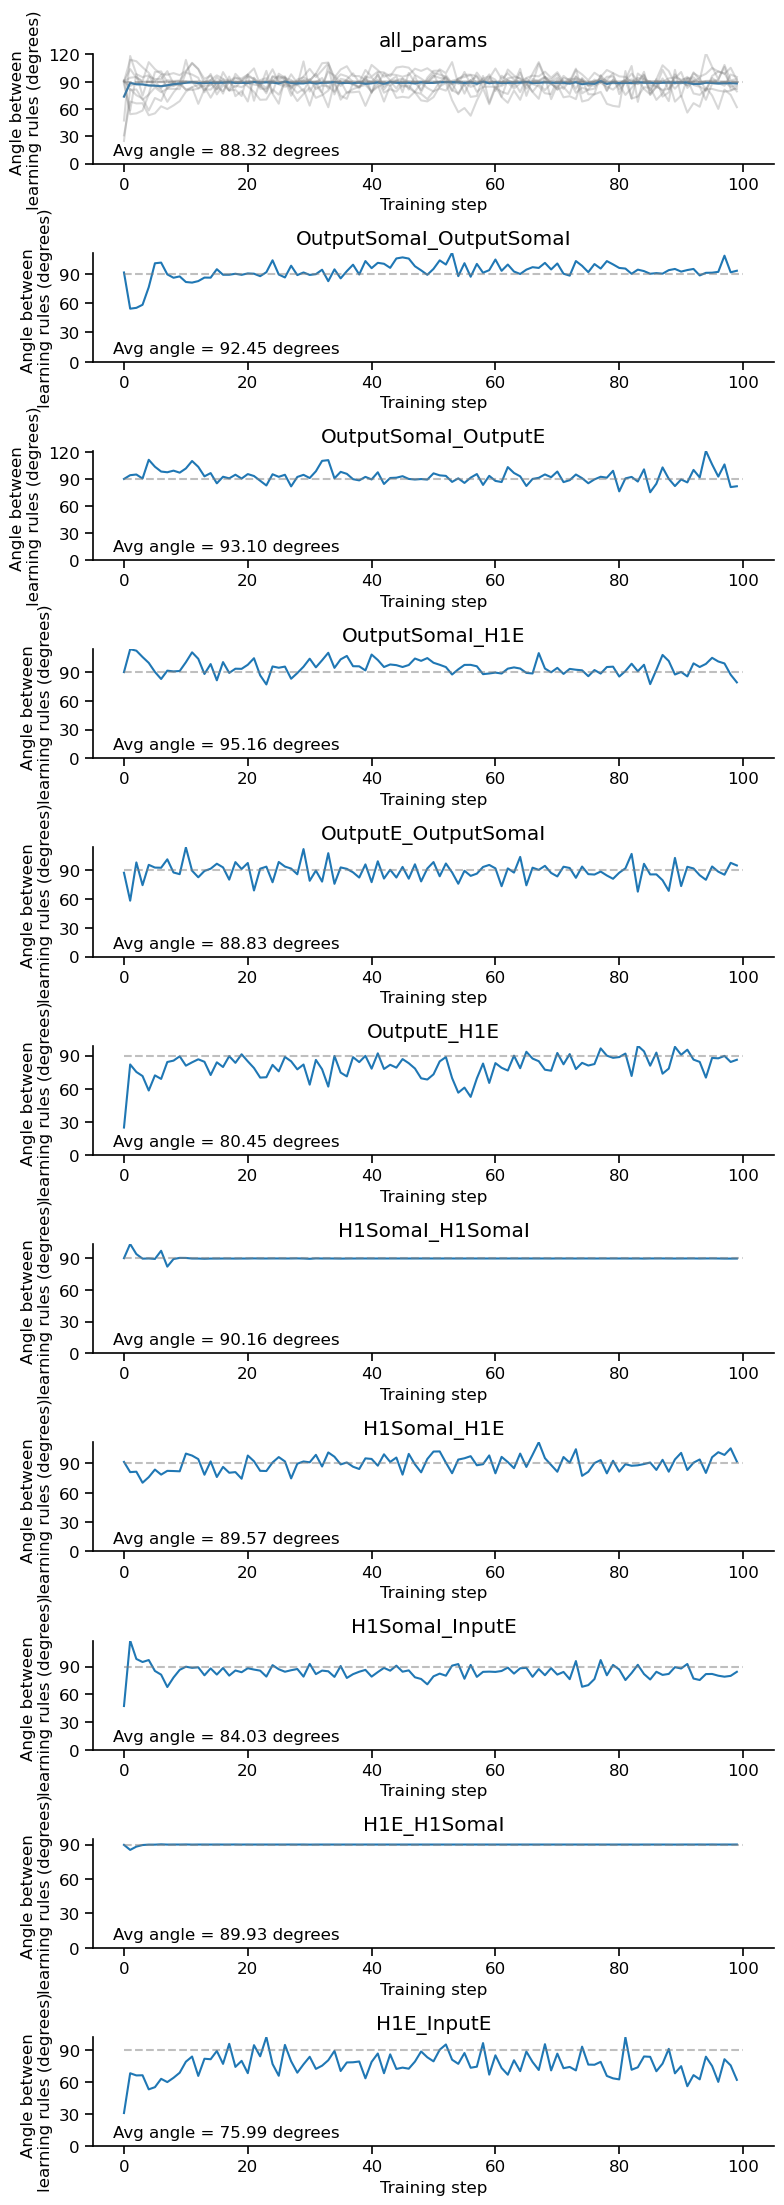

In [26]:
angles = ut.compute_dW_angles(bpClone_network, plot=True)


# Backprop network

In [4]:
# Create network
network_name = "EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml"
network_config = ut.read_from_yaml(f'../config/MNIST_templates/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [5]:
# # Load pretrained network
# saved_network_path = f"saved_networks/{network_name}.pickle"
# bp_network.load(saved_network_path)

# pt.plot_batch_accuracy(bp_network, test_dataloader, population=bp_network.H1.E)
# pt.plot_rsm(bp_network,test_dataloader)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:206: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:226: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


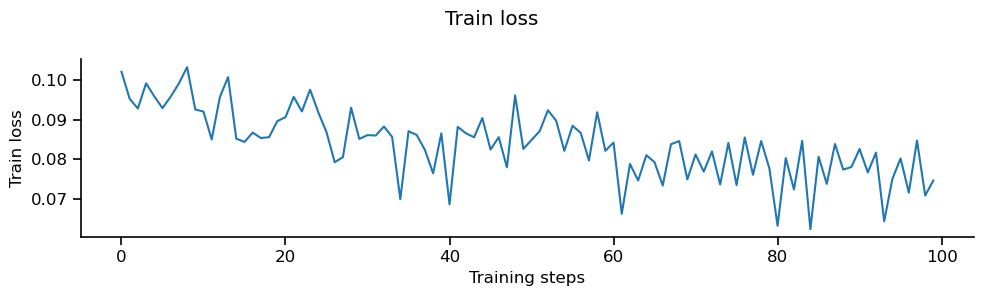

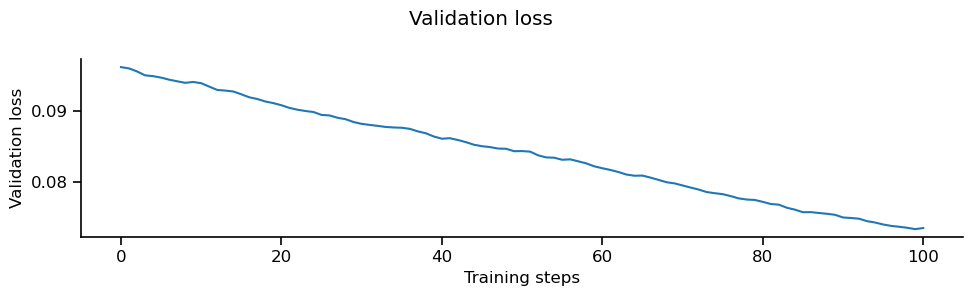

In [6]:
# Train network
data_generator.manual_seed(data_seed)
bp_network.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=epochs,
                val_interval=(0,100,1),
                store_history=True, 
                store_params=True,
                status_bar=True)

# bp_network.save(file_name_base=network_name)

# pt.plot_batch_accuracy(bp_network, test_dataloader, population=bp_network.H1.E)
pt.plot_train_loss_history(bp_network)
pt.plot_validate_loss_history(bp_network)

In [ ]:
angles = ut.compute_dW_angle_vs_BP(test_dataloader, bp_network)

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
# bp_network.load_state_dict(bp_network.param_history[0])

# idx, data, target = next(iter(test_dataloader))
# output = bp_network.forward(data)

# # w1 = bp_network.module_dict['H1E_InputE'].weight.detach().clone()
# w1 = bp_network.param_history[0]['module_dict.H1E_InputE.weight']

# bp_network.zero_grad()
# loss = bp_network.criterion(output, target)
# loss.backward()

# grad = bp_network.H1.E.Input.E.weight.grad
# bp_network.optimizer.step()

# # w2 = bp_network.module_dict['H1E_InputE'].weight.detach().clone()
# w2 = bp_network.param_history[1]['module_dict.H1E_InputE.weight']
# dW = w1 - w2



In [ ]:
pt.plot_hidden_weights(bp_network.module_dict['H1E_InputE'].weight, sort=True) 

In [ ]:
network = bp_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
metrics_dict['val_loss'] =  network.val_loss_history
metrics_dict['val_loss_steps'] = network.val_history_train_steps

ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

# Backprop Dale network

In [ ]:
# Create network
# network_name = "EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config"
# network_config = ut.read_from_yaml(f'../config/MNIST/{network_name}.yaml')

network_name = "20230102_EIANN_1_hidden_mnist_bpDale_softplus_config.yaml"
network_config = ut.read_from_yaml(f'../optimize/data/mnist/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
# # Load pretrained network
# saved_network_path = f"saved_networks/{network_name}.pickle"
# bpDale_network.load(saved_network_path)

# pt.plot_batch_accuracy(bpDale_network, test_dataloader, population=bpDale_network.H1.E)
# pt.plot_rsm(bpDale_network,test_dataloader)

In [ ]:
# Train network
data_generator.manual_seed(data_seed)
bpDale_network.train(train_sub_dataloader, 
                              test_dataloader, 
                              epochs=epochs,
                              val_interval=(0,-1,1000),
                              store_history=True, 
                              store_params=True,
                              status_bar=True)

bpDale_network.save(file_name_base=network_name)

pt.plot_batch_accuracy(bpDale_network, test_dataloader, population=bpDale_network.H1.E)
plt.figure()
pt.plot_train_loss_history(bpDale_network)
plt.show()

In [ ]:
network = bpDale_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
metrics_dict['val_loss'] =  network.val_loss_history
metrics_dict['val_loss_steps'] = network.val_history_train_steps

ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

In [ ]:
pt.plot_hidden_weights(bpDale_network.module_dict['H1E_InputE'].weight, sort=True)

In [ ]:
weights = bpDale_network.module_dict['H1E_InputE'].weight.detach()
ut.compute_representation_metrics(bpDale_network.H1.E, test_dataloader, receptive_fields=weights, plot=True)

In [ ]:
population = bpDale_network.Output.E
# receptive_fields, activity_preferred_inputs = ut.compute_act_weighted_avg(population, test_dataloader)
_, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=True)
receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
pt.plot_receptive_fields(receptive_fields, activity_preferred_inputs)

In [ ]:
population = bpDale_network.Output.FBI
# receptive_fields, activity_preferred_inputs = ut.compute_act_weighted_avg(population, test_dataloader)
_, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=True)
receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
pt.plot_receptive_fields(receptive_fields, activity_preferred_inputs)

In [ ]:
pt.plot_correlations(bpDale_network, test_dataloader)

In [ ]:
pt.plot_total_input(bpDale_network.H1.E, test_dataloader, sorting='EI_balance', act_threshold=0)

# Gjorgjieva Hebb network

In [ ]:
# Create network
# network_name = "20230103_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_B"
# network_config = ut.read_from_yaml('../optimize/data/20221229_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config.yaml')
# network_config = ut.read_from_yaml('../config/MNIST/EIANN_0_hidden_mnist_Gjorgjieva_Hebb_config.yaml')
# network_config = ut.read_from_yaml(f'../optimize/data/{network_name}.yaml')

network_name = '20230214_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_C.yaml'
network_config = ut.read_from_yaml(f'../optimize/data/mnist/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

gj_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
# # Load pretrained network
# saved_network_path = f"saved_networks/{network_name}.pickle"
# gj_network.load(saved_network_path)

# pt.plot_batch_accuracy(gj_network, test_dataloader, population=gj_network.H1.E)
# pt.plot_rsm(gj_network,test_dataloader)

In [ ]:
# Train network
data_generator.manual_seed(data_seed)
gj_network.train(train_sub_dataloader, 
                              test_dataloader, 
                              epochs=epochs,
                              val_interval=(0,-1,1000),
                              store_history=True, 
                              store_params=False, 
                              status_bar=True)

gj_network.save(file_name_base=network_name)

pt.plot_batch_accuracy(gj_network, test_dataloader, population=gj_network.H1.E)
plt.figure()
pt.plot_train_loss_history(gj_network)
plt.show()

In [ ]:
network = gj_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
metrics_dict['val_loss'] =  network.val_loss_history
metrics_dict['val_loss_steps'] = network.val_history_train_steps

ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

In [ ]:
pt.plot_hidden_weights(gj_network.module_dict['H1E_InputE'].weight, sort=True)

In [ ]:
population = gj_network.Output.E
# receptive_fields, activity_preferred_inputs = ut.compute_act_weighted_avg(population, test_dataloader)
# _, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=True)
receptive_fields, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
pt.plot_receptive_fields(receptive_fields, activity_preferred_inputs)

In [ ]:
pt.plot_correlations(gj_network, test_dataloader)

In [ ]:
pt.plot_total_input(gj_network.H1.E, test_dataloader, sorting='EI_balance', act_threshold=0)

# BTSP network

In [ ]:
# Create network
# network_name = "20230104_EIANN_1_hidden_mnist_BTSP_config_F"
# network_config = ut.read_from_yaml(f'../optimize/data/{network_name}.yaml')

network_name = 'EIANN_1_hidden_mnist_BTSP_config.yaml'
network_config = ut.read_from_yaml(f'../config/MNIST_templates/{network_name}')

# network_name = '20230214_1_hidden_mnist_BTSP_Clone_Dend_I_1_bad.yaml'
# network_name = '20230220_1_hidden_mnist_BTSP_Clone_Dend_I_4.yaml'
# network_config = ut.read_from_yaml(f'../optimize/data/mnist/{network_name}')

# network_name = 'EIANN_1_hidden_mnist_BTSP_CloneDend.yaml'
# network_config = ut.read_from_yaml(f'../config/MNIST/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

In [ ]:
# # Load pretrained network
# saved_network_path = f"saved_networks/{network_name}.pkl"
# # saved_network_path = f"saved_networks/{network_name}.pickle"
# # saved_network_path = f"saved_networks/{network_name}_early.pickle"

# btsp_network.load(saved_network_path)

# pt.plot_batch_accuracy(btsp_network, test_dataloader, population=btsp_network.H1.E)
# pt.plot_rsm(btsp_network,test_dataloader)

In [ ]:
# Train network
data_generator.manual_seed(data_seed)
btsp_network.train(train_sub_dataloader, 
                                test_dataloader, 
                                epochs=epochs,
                                val_interval=(0,-1,1000),
                                store_history=True, 
                                store_params=False, 
                                status_bar=True)

pt.plot_batch_accuracy(btsp_network, test_dataloader, population=btsp_network.H1.E)
plt.figure()
pt.plot_train_loss_history(btsp_network)
plt.show()
pt.plot_rsm(btsp_network,test_dataloader)

btsp_network.save(file_name_base=network_name)

In [ ]:
pt.plot_hidden_weights(btsp_network.module_dict['H1E_InputE'].weight, sort=True)

In [ ]:
pt.plot_plateaus(population=btsp_network.Output.E, start=0, end=10000)

In [ ]:
pt.plot_plateaus(population=btsp_network.H1.E, start=0, end=10000)

In [ ]:
sorted_plateaus, unit_ids = pt.plot_sorted_plateaus(btsp_network.Output.E, test_dataloader)

In [ ]:
sorted_plateaus, unit_ids = pt.plot_sorted_plateaus(btsp_network.H1.E, test_dataloader)

In [ ]:
network = btsp_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
metrics_dict['val_loss'] =  network.val_loss_history
metrics_dict['val_loss_steps'] = network.val_history_train_steps

ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

In [ ]:
# pt.plot_hidden_weight_history(btsp_network, unit=368)

In [ ]:
population = btsp_network.Output.E
_, activity_preferred_inputs = ut.compute_act_weighted_avg(population, test_dataloader)
# _, activity_preferred_inputs = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=True)
receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
pt.plot_receptive_fields(receptive_fields, activity_preferred_inputs)

In [ ]:
pt.plot_correlations(btsp_network, test_dataloader)

In [ ]:
pt.plot_total_input(btsp_network.H1.E, test_dataloader, sorting='EI_balance', act_threshold=0)